<a href="https://colab.research.google.com/github/Samin-Sadaf7/NN_works/blob/main/MicroGrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**`Original idea and works:  Andrej Karpathy`**

In [37]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def func(x):
  return 2*x**2+4*x-7

In [3]:
func(3.0)

23.0

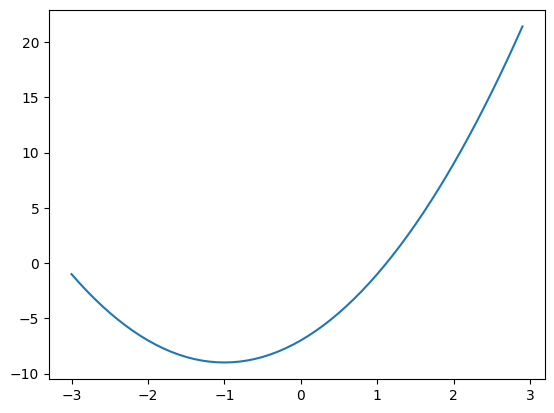

In [4]:
xs = np.arange(-3, 3,0.1)
ys = func(xs)
plt.plot(xs, ys)

###Derivative

Let  a∈R
  and let  f(x)
  be defined on an open interval 6 that contains  a.

The derivative of  f(x)
  at  x=a
  is denoted  f′(a)
  and is defined by
f′(a)=limh→0f(a+h)−f(a)h

if the limit exists.
When the above limit exists, the function  f(x)
  is said to be differentiable at  x=a.
  When the limit does not exist, the function  f(x)
  is said to be not differentiable at  x=a.

We can equivalently define the derivative  f′(a)
  by the limit
f′(a)=limx→af(x)−f(a)x−a.

To see that these two definitions are the same, we set  x=a+h
  and then the limit as  h
  goes to  0
  is equivalent to the limit as  x
  goes to  a.

In [5]:
h = 0.0000001
x = -2.5
(func(x+h)-func(x))/h

-5.99999978589949

In [6]:
a = 2.0
b = -3.0
c = 4.0
d = a*b +c
print(d)

-2.0


In [7]:
h = 0.001
#inputs
a = 2.0
b = -3.0
c = 4.0

d1 = a*b +c
a+=h
d2 = a*b +c
print('d1:', d1)
print('d2:', d2)
print("slope d with respect to a :" , (d2-d1)/h)

d1: -2.0
d2: -2.003
slope d with respect to a : -3.0000000000001137


In [8]:
h = 0.001
#inputs
a = 2.0
b = -3.0
c = 4.0

d1 = a*b +c
b+=h
d2 = a*b +c
print('d1:', d1)
print('d2:', d2)
print("slope d with respect to b :" , (d2-d1)/h)

d1: -2.0
d2: -1.9980000000000002
slope d with respect to b : 1.9999999999997797


In [9]:
h = 0.001
#inputs
a = 2.0
b = -3.0
c = 4.0

d1 = a*b +c
c+=h
d2 = a*b +c
print('d1:', d1)
print('d2:', d2)
print("slope d with respect to c :" , (d2-d1)/h)

d1: -2.0
d2: -1.9989999999999997
slope d with respect to c : 1.000000000000334


### Need a Data Structure to wrap up the data  in Neural Network
Building the core of MicroGrad

In [97]:
class Value:
  # constructor in python
  def __init__(self, data, _children=(), _op=(), label=''):
    self.data = data
    self._prev = set(_children)
    self._backward = lambda:None
    self.grad = 0.0
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data:{self.data})"

  #operator overloading in python
  def __add__(self, other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data, (self, other),'+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data, (self, other),'*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __rmul__(self, other): #other * self
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float)),"only supports int/float for now"
    out = Value(self.data ** other,(self,), f'**{other}')
    def _backward():
      self.grad += other*(self.data ** (other-1)) * out.grad

    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self * other ** -1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward

    return out

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def exp(self):
    val = self.data
    out = Value(math.exp(val), (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward
    return out

  def backward(self):

    #Combining everything below to create an automated backpropagation

    topo = []
    visited = set()

    def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._prev:
             build_topo(child)
          topo.append(v)

    self.grad = 1.0
    build_topo(self)
    for node in reversed(topo):
        node._backward()


In [98]:
a = Value(6.0)
b = Value(4.0)
print(a/b)
print(a-b)

Value(data:1.5)
Value(data:2.0)


In [39]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label , n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [69]:
a= Value(2.0, label='a')
b= Value(-3.0, label = 'b')
c= Value(-4,label ='c')
e= a*b
e.label='e'
d = e + c
d.label='d'
f = Value( -2.0, label = 'f')
L = d*f
L.label='L'
L

Value(data:20.0)

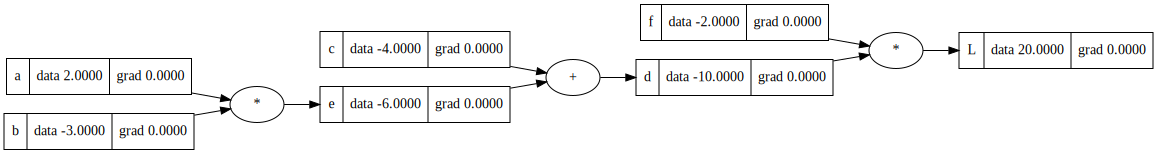

In [70]:
draw_dot(L)

In [13]:
# Manual Backpropagation
L.grad = 1.0
d.grad = f.data
f.grad = d.data
c.grad = d.grad * 1.0
e.grad = d.grad * 1.0
b.grad = e.grad * a.data
a.grad = e.grad * b.data

In [15]:
# Sinlge optimization run
a.data += (0.01 * a.grad)
b.data += (0.01 * b.grad)
c.data += (0.01 * c.grad)
f.data += (0.01 *  f.grad)

e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
L = d + f
L.label ='L'
print(L.data)

-12.382399999999999


In [17]:
def man_def():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(-4.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(-4.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  f.data+=h
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

man_def()

-9.99999999999801


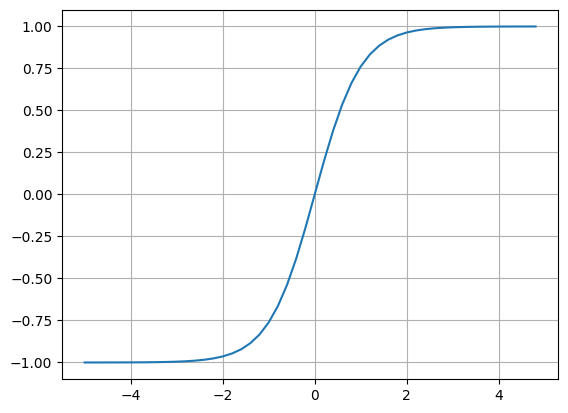

In [18]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [99]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, 2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of neuron b
b = Value(6.8880212, label ='b')
#x1*w1+x2*w2+b
x1w1 = x1*w1 ; x1w1.label = 'x1w1'
x2w2 = x2*w2 ; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+ x2w2 ; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b ; n.label='n'
o = n.tanh() ; o.label ='o'

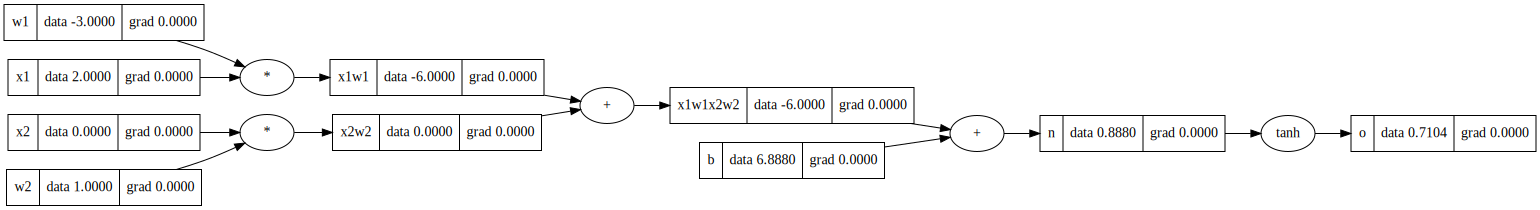

In [100]:
draw_dot(o)

In [91]:
o.backward()

In [56]:
## Building a topological sort
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data:6.8880212),
 Value(data:1.0),
 Value(data:0.0),
 Value(data:0.0),
 Value(data:2.0),
 Value(data:-3.0),
 Value(data:-6.0),
 Value(data:-6.0),
 Value(data:0.8880211999999998),
 Value(data:-0.9866142981514304)]

In [45]:
o.grad = 1.0

In [46]:
o._backward()

In [48]:
n._backward()

In [50]:
b._backward()

In [51]:
x1w1x2w2._backward()

In [53]:
x1w1._backward()

In [54]:
x2w2._backward()

In [35]:
#Manual Backpropagation -- part 2
o.grad = 1
n.grad = 1 - (o.data ** 2)
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = n.grad
x2w2.grad = n.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [101]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, 2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of neuron b
b = Value(6.8880212, label ='b')
#x1*w1+x2*w2+b
x1w1 = x1*w1 ; x1w1.label = 'x1w1'
x2w2 = x2*w2 ; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+ x2w2 ; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b ; n.label='n'
## --- redefine tanh ---

e = (2*n).exp() ; e.label ='e'
o = (e-1)/(e+1) ; o.label ='o'
o.backward()

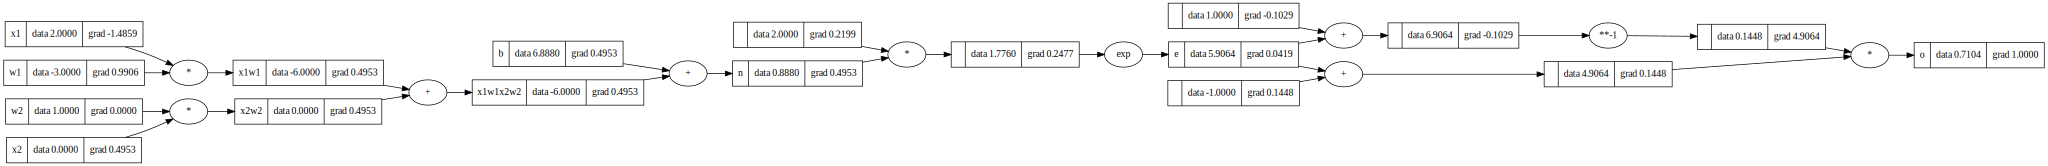

In [102]:
draw_dot(o)

###Implementing the Same thing using Pytorch
Tensors are mostly made to use for matrix , vector or 2D arrays. By default, Pytorch assumes that all the tensorsa are leaf nodes and does not require gradient. That's why, we explicitly mention that the gradients are required for the varibles.

In [103]:
import torch

In [108]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
